# SIR calibration demo

## Learning parameters from a single dataset

In this Jupyter notebook, we will demonstrate the basics of the methodology of calibrating a single dataset without adding too much computational complexity. The idea is just to set up a simple ODE model, calibrate its parameters, and plot the results, illustrating the basic idea of the methodology. With this approach, you can already learn system parameters from a single observation time series. However, the methodology can also be used to learn parameters from multiple observations, or to train a neural network to learn different parameters from different observations. These will be demonstrated in future notebooks and models as I expand the methodology.

Let's get started by first importing the required packages -- make sure they are installed on your system:

In [1]:
import numpy as np
import tqdm
import torch
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

Next we import neural network generation function from `include.neural_network`:

In [2]:
from include import neural_net

Ok, let's first generate some synthetic SIR data. The originaal function (as with all models) is located in the `<model_name>/DataGeneration.py` folder. You can adapt these to your own needs, or come up your own structure. For our purposes, lets rewrite the function and reuse it later on for training.

In [3]:
def generate_SIR_data(*,
        cfg: dict,
        num_steps: int,
        init_state: torch.tensor,
        dt: float = 1
):
    """ Forward Euler solver for the SIR model."""
    data = [init_state]
    
    for i in range(num_steps):        
        
        # Recovery rate, which is truncated in time. Since the Heaviside function is not differentiable, 
        # we use a very steep sigmoid, which looks almost the same
        tau = 1 / cfg["t_infectious"] * torch.sigmoid(1000 * (i / cfg["t_infectious"] - 1))
        
        # Solve the ODE using a forward Euler
        data.append(
           torch.clip(data[-1] + torch.stack(
                [
                    (-cfg["p_infect"] * data[-1][0] + cfg["sigma"] * torch.normal(0.0, 1.0, size=(1, )))
                    * data[-1][1],
                    (cfg["p_infect"] * data[-1][0] - tau + cfg["sigma"] * torch.normal(0.0, 1.0, size=(1, )))
                    * data[-1][1],
                    tau * data[-1][1],
                ]
            ) * dt, 0, 1)
        )
    
    # Return the time series
    return torch.stack(data)

Now let's generate some training data. Let's assume that 1% of the population are infected at time `t=0` and use this as the initial data:

In [4]:
# Generate an initial state and run the model:
init_state = torch.tensor([0.99, 0.01, 0], dtype=torch.float).reshape(-1, 1)
SIR_data = generate_SIR_data(
    cfg={
        "t_infectious": torch.tensor(14),
        "p_infect": torch.tensor(0.2), 
        "sigma": torch.tensor(0.1)
    }, 
    num_steps=1000, 
    init_state=init_state,
    dt=0.1
)
print(SIR_data.shape)

torch.Size([1001, 3, 1])


In [14]:
SIR_data

tensor([[[0.9900],
         [0.0100],
         [0.0000]],

        [[0.9898],
         [0.0102],
         [0.0000]],

        [[0.9898],
         [0.0104],
         [0.0000]],

        ...,

        [[0.0870],
         [0.0218],
         [0.9481]],

        [[0.0867],
         [0.0217],
         [0.9483]],

        [[0.0865],
         [0.0217],
         [0.9484]]])

In [5]:
SIR_data_xr

NameError: name 'SIR_data_xr' is not defined

Let's quickly plot the training to see what it looks like. Converting to an xarray dataset makes this more convenient, and also illustrates how the `utopya` DAG framework works -- but this is optional, you can of course just plot using matplotlib directly if you prefer:

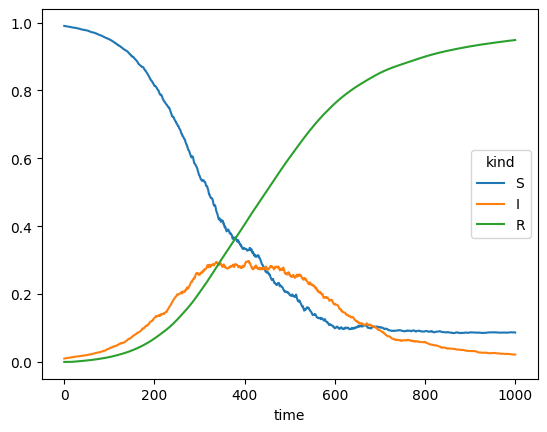

In [9]:
SIR_data_xr = xr.DataArray(data=SIR_data.squeeze(), 
                           dims=["time", "kind"], 
                           coords={"time": np.arange(SIR_data.shape[0]), "kind": ["S", "I", "R"]})
SIR_data_xr.plot.line(hue="kind");

Okay -- looks good. Now let's train a neural network to calibrate just this one single dataset. If you have many different datasets with many different parameters, the procedure would be analogous but with a larger training set. 

We want to learn two parameters: p_infect and t_infectious. First, let's initialise a neural network to take an (S, I, R) vector as input and output two predicted parameters. We'll use a small net with 3 layers, 20 neurons per layer, and sigmoid activation functions on all layers except the last, where we use the absolute value:

In [10]:
NN = neural_net.NeuralNet(
    input_size = SIR_data.shape[1], # We have S, I, R compartments
    output_size = 2, # We want to learn 2 parameters
    num_layers=3,
    nodes_per_layer={"default": 20}, 
    activation_funcs={"default": "sigmoid", "layer_specific": {-1: "abs"}}, 
    biases={"default": None}
)
# All other parameters (optimizer, learning rate etc.) are the default -- see include.neural_net.NeuralNet for details

# Store the loss and parameters in an array
loss_ts, parameters_ts = [], []

All right -- now let's train, and track the loss and parameters as the neural network trains. We need to decide how often to make a gradient descent step, and with such long time series it's typically best to use a batch size of at least half the length of the time series, so that the neural network gets to see more of the structure of the data before optimising its parameters. The time series is 100 steps long, so let's just set the batch size to 100, for simplicity.

In [11]:
# Generate some batch slices:
batch_size = 1000
batches = np.arange(0, SIR_data.shape[0], batch_size)
print(batches)

[   0 1000]


In [12]:
SIR_data.shape[0]

1001

The following training routine should run in about 60 seconds on a reasonably fast computer:

In [13]:
num_epochs = 300

for _ in (pbar:= tqdm.tqdm(range(num_epochs))):
            
    # Now iterate over the time series in batches and perform a gradient descent step after every batch
    for idx in range(len(batches)-1):
        
        # Initial frame
        init_state = SIR_data[idx]
        
        # Make a prediction from the initial frame
        predicted_parameters = NN(init_state.squeeze())
        
        # Generate a predicted time series with zero noise
        predicted_time_series = generate_SIR_data(
            cfg={
                "p_infect": predicted_parameters[0],
                "t_infectious": predicted_parameters[1],
                "sigma": torch.tensor(0.0)
            }, 
            num_steps = batch_size - 1,
            init_state = init_state, 
            dt=0.1
        )
        
        # Calculate the loss
        loss = torch.nn.functional.mse_loss(
            SIR_data[batches[idx]+1:batches[idx+1]], predicted_time_series[1:]
        )
        
        # Perform a gradient descent step
        loss.backward()
        NN.optimizer.step()
        NN.optimizer.zero_grad()
        
        # Store prediction and loss
        loss_ts.append(loss.clone().detach())
        parameters_ts.append(predicted_parameters.clone().detach())
    
        pbar.set_description(f"Current loss: {loss}")

  0%|          | 0/300 [00:39<?, ?it/s]


KeyboardInterrupt: 

Let's plot the loss to see how it developed:

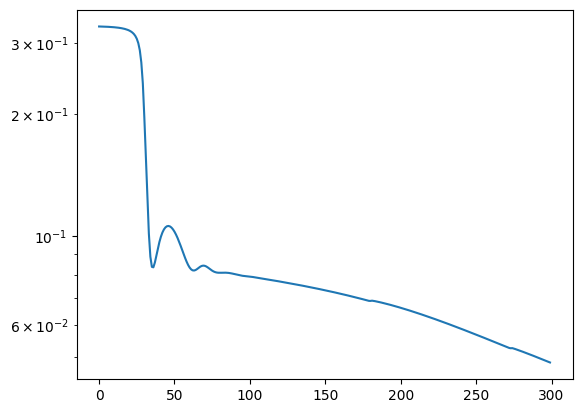

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(loss_ts)), loss_ts)
ax.set_yscale('log')

Looks reasonable -- let's take a look at the evolution of the parameters, again using xarray for simplicity:

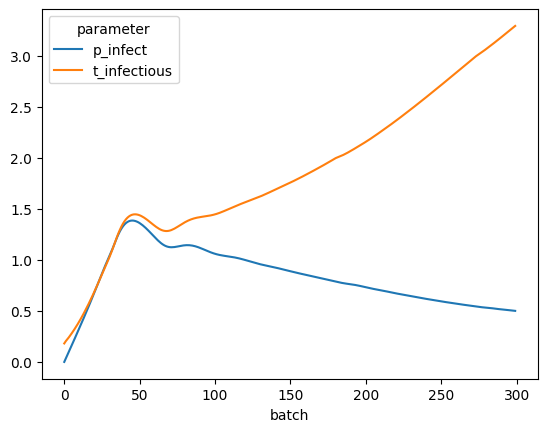

In [10]:
parameters_ts_xr = xr.DataArray(
    data=torch.stack(parameters_ts),
    dims=["batch", "parameter"],
    coords={"batch": np.arange(len(parameters_ts)), "parameter": ["p_infect", "t_infectious"]}
)

parameters_ts_xr.plot.line(hue="parameter");

We can see that model is moving towards the true values, but very slowly. The problem is that the two parameters to be learned are two orders of magnitude apart, and this means that the gradients are skewed, slowing the training process immensely. We can speed this up by adding scaling factors to the outputs:

In [11]:
scaling = torch.tensor([1, 10])

Let's reset everything and run again:

In [12]:
NN = neural_net.NeuralNet(
    input_size = SIR_data.shape[1],
    output_size = 2,
    num_layers=3,
    nodes_per_layer={"default": 20}, 
    activation_funcs={"default": "sigmoid", "layer_specific": {-1: "abs"}}, 
    biases={"default": None}
)
loss_ts, parameters_ts = [], []

for _ in (pbar:= tqdm.tqdm(range(num_epochs))):
            
    # Now iterate over the time series in batches and perform a gradient descent step after every batch
    for idx in range(len(batches)-1):
        
        # Initial frame
        init_state = SIR_data[idx]
        
        # Make a prediction from the initial frame
        predicted_parameters = scaling * NN(init_state.squeeze())
        
        # Generate a predicted time series with zero noise
        predicted_time_series = generate_SIR_data(
            cfg={
                "p_infect": predicted_parameters[0],
                "t_infectious": predicted_parameters[1],
                "sigma": torch.tensor(0.0)
            }, 
            num_steps = batch_size - 1,
            init_state = init_state, 
            dt=0.1
        )
        
        # Calculate the loss
        loss = torch.nn.functional.mse_loss(
            SIR_data[batches[idx]+1:batches[idx+1]], predicted_time_series[1:]
        )
        
        # Perform a gradient descent step
        loss.backward()
        NN.optimizer.step()
        NN.optimizer.zero_grad()
        
        # Store prediction and loss
        loss_ts.append(loss.clone().detach())
        parameters_ts.append(predicted_parameters.clone().detach())
    
        pbar.set_description(f"Current loss: {loss}")

Current loss: 0.0035710036754608154: 100%|██████████| 300/300 [00:52<00:00,  5.75it/s]


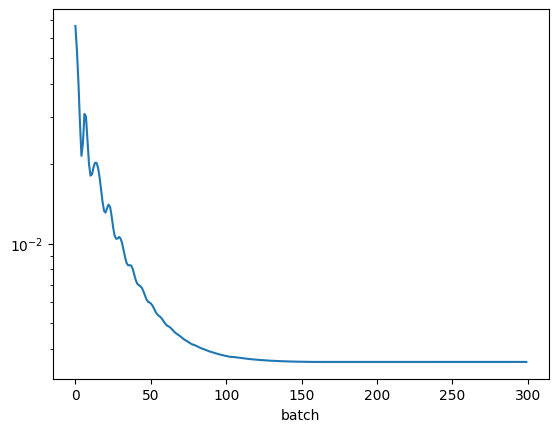

In [13]:
fig, ax = plt.subplots()
loss_ts_xr = xr.DataArray(data=loss_ts, dims=["batch"], coords={"batch": np.arange(len(loss_ts))})
loss_ts_xr.plot.line(ax=ax)
ax.set_yscale('log');

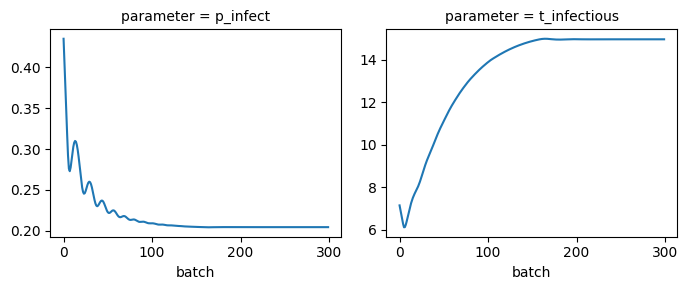

In [14]:
parameters_ts_xr = xr.DataArray(
    data=torch.stack(parameters_ts),
    dims=["batch", "parameter"],
    coords={"batch": np.arange(len(parameters_ts)), "parameter": ["p_infect", "t_infectious"]}
)
parameters_ts_xr.plot.line(col="parameter", sharey=False);

This looks much better!

Let's plot the joint distribution of all the parameters we've estimated; we can do so using the `joint_2D_ds` function, located in `model_plots.data_ops`:

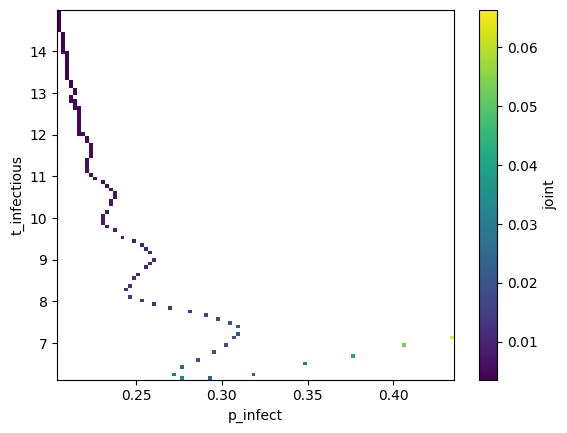

In [24]:
from model_plots.data_ops import joint_2D_ds
joint = joint_2D_ds(parameters_ts_xr, loss_ts_xr, x="p_infect", y="t_infectious")
joint.plot.imshow(x="p_infect")

We can see the single path that the neural network traced out on its way to the minimum at (0.2, 14). To truly get a sense of the joint distribution, we would need to train the neural network multiple times from different initialisations, ideally in parallel. All this is implemented in the utopya version of the model. We recommend you now continue to the main tutorial in the README.